# Compute change in temperature from ERF

This notebook takes the ERF dataset created in notebook 1 and computes the change in temperature from each forcing according to an impulse response function

### Imports


In [1]:
import pandas as pd
import xarray as xr
from IPython.display import clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
from ar6_ch6_rcmipfigs.constants import INPUT_DATA_DIR

/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs
/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/data_in


In [20]:
from openscm_twolayermodel import ImpulseResponseModel, TwoLayerModel, constants  # pip install openscm-twolayermodel
from openscm_units import unit_registry  # pip install openscm-units
from scmdata import ScmRun  # pip install scmdata

/home/sarambl/miniconda3/envs/rcmip_ch6/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


<IPython.core.display.Javascript object>

### General about computing $\Delta T$:

We compute the change in GSAT temperature ($\Delta T$) from the effective radiative forcing (ERF) from MAGICC?????? (#TODO: check model and reference), by integrating with the impulse response function (IRF(t-t'))

#todo: check for ref for IRF
(Geoffroy at al 2013).

For any forcing agent $x$, with estimated ERF$_x$, the change in temperature $\Delta T$ is calculated as:


\begin{align*}
\Delta T_x (t) &= \int_0^t ERF_x(t') IRF(t-t') dt' \\
\end{align*}

#### The Impulse response function (IRF):
In these calculations we use:
\begin{align*}
IRF(t) = \frac{q_1}{d_1} \exp\Big(\frac{-t}{d_1}\Big) + \frac{q_2}{d_2} \exp\Big(\frac{-t}{d_2}\Big)
\end{align*}

Where the constants, $q_i$ and $d_i$ are shown below. 

**TODO: find ref**

## Input data:
See [README.md](../../README.md)

# Code + figures

In [2]:
fn_IRF_constants = INPUT_DATA_DIR /'recommended_irf_from_2xCO2_2021_02_25_222758.csv'

irf_consts = pd.read_csv(fn_IRF_constants).set_index('id')

ld1 = 'd1 (yr)'
ld2 = 'd2 (yr)'
lq1 = 'q1 (K / (W / m^2))'
lq2 = 'q2 (K / (W / m^2))'
median = 'median'
perc5 = '5th percentile'
perc95 = '95th percentile'
recommendation = 'recommendation'
irf_consts  # [d1]

,C (W yr / m^2 / K),C_d (W yr / m^2 / K),alpha (W / m^2 / K),eta (dimensionless),kappa (W / m^2 / K),d1 (yr),d2 (yr),q1 (K / (W / m^2)),q2 (K / (W / m^2)),efficacy (dimensionless),ecs (K),tcr (K),rf2xCO2 (W / m^2)
id,,,,,,,,,,,,,
recommendation,7.649789,147.168593,1.31,1.027856,0.880636,3.424102,285.003478,0.443768,0.319591,1.027856,3.0,1.801052,3.93


In [37]:
# lets get the irf values from 0 until i
d1 = float(irf_consts[ld1])
d2 = float(irf_consts[ld2])
q1 = float(irf_consts[lq1])
q2 = float(irf_consts[lq2])
eff = float(irf_consts['efficacy (dimensionless)'])
print(f'd1={d1}, d2={d2}, q1={q1}, q2={q2}')

d1=3.4241020923110033, d2=285.0034778419114, q1=0.4437677288834471, q2=0.31959104974250885


In [4]:
# lets get the irf values from 0 until i
d1 = float(irf_consts[ld1])
d2 = float(irf_consts[ld2])
q1 = float(irf_consts[lq1])
q2 = float(irf_consts[lq2])

print(f'd1={d1}, d2={d2}, q1={q1}, q2={q2}')

d1=3.4241020923110033, d2=285.0034778419114, q1=0.4437677288834471, q2=0.31959104974250885


### Path input data

In [5]:
from ar6_ch6_rcmipfigs.constants import OUTPUT_DATA_DIR, RESULTS_DIR

PATH_DATASET = OUTPUT_DATA_DIR / 'ERF_data.nc'

## Path output data

In [6]:
PATH_DT_TAB_OUTPUT = RESULTS_DIR / 'tables' / 'table_sens_dT_cs_recommandetion.csv'
PATH_DT_OUTPUT = OUTPUT_DATA_DIR / 'dT_data_RCMIP_recommendation.nc'

print(PATH_DT_OUTPUT)

/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/data_out/dT_data_RCMIP_recommendation.nc


## various definitions

In [7]:
# name of output variable
name_deltaT = 'Delta T'

climatemodel = 'climatemodel'
scenario = 'scenario'
variable = 'variable'
time = 'time'
percentile = 'percentile'

## Set values:

We only compute for the recommendation (not e.g. percentiles):

In [8]:
IRFpercentiles = [recommendation]
# {'ECS = 2K':0.526, 'ECS = 3.4K':0.884, 'ECS = 5K': 1.136 }

Year to integrate from and to:

In [9]:
first_y = 1750
last_y = 2100

**Set reference year for temperature change:**

In [10]:
ref_year = 2019

**Years to output change in**

In [11]:
years = [2040, 2100]

### Define variables to look at:

In [12]:
# variables to plot:
variables_erf_comp = [
    'ch4',
    'aerosol-radiation_interactions',
    'aerosol-cloud_interactions',
    'aerosol-total',
    'o3',
    'HFCs',
    # 'F-Gases|HFC',
    'bc_on_snow',
    'total_anthropogenic',
    'total',
]
# total ERFs for anthropogenic and total:
variables_erf_tot = ['total_anthropogenic',
                     'total']
variables_all = variables_erf_comp + variables_erf_tot
# Scenarios to plot:
scenarios_fl = ['ssp534-over', 'ssp119', 'ssp334','ssp460', 'ssp585', 'ssp370',
                'ssp370-lowNTCF-aerchemmip', 'ssp126', 'ssp245', 'ssp434',
                'ssp370-lowNTCF-gidden'
                ]

## IRF function: 

In [13]:

def IRF(t, d1, q1, d2, q2):
    """
    Returns the IRF function for:
    :param q2:
    :param d2:
    :param q1:
    :param d1:
    :param t: Time in years
    :return:
    IRF
    """
    irf = q1 / d1 * np.exp(-t / d1) + q2 / d2 * np.exp(-t / d2)
    return irf
    # l * (alpha1 * np.exp(-t / tau1) + alpha2 * np.exp(-t / tau2))

### Open ERF dataset:

In [14]:
ds = xr.open_dataset(PATH_DATASET).sel(year=slice(1700, 2200))  # we need only years until 1700
da_ERF = ds['ERF']

#### Simple pre-processing

In [15]:
ds['time'] = pd.to_datetime(ds['year'].to_pandas().index.map(str), format='%Y')

# delta_t is 1 (year)
ds['delta_t'] = xr.DataArray(np.ones(len(ds['year'])), dims='year', coords={'year': ds['year']})

## Integrate and compute $\Delta T$:
The code below integrates the read in ERFs with the pre defined impulse response function (IRF).

\begin{align*} 
\Delta T (t) &= \int_0^t ERF(t') IRF(t-t') dt' \\
\end{align*}

In [16]:


def integrate_(i, _var, _nvar, ds_in: xr.Dataset, ds_DT, irf_cnst: dict):
    """

    :param i:
    :param _var:
    :param _nvar:
    :param ds_in:
    :param ds_DT:
    :param irf_cnst: dictionary
    :return:
    """
    # lets create a ds that goes from 0 to i inclusive
    ds_short = ds_in[{'year': slice(0, i + 1)}].copy()
    #print(ds_short)
    # lets get the current year
    current_year = ds_short['year'][{'year': i}]  # .dt.year
    # lets get a list of years
    _years = ds_short['year']  # .dt.year
    # lets get the year delta until current year(i)
    ds_short['end_year_delta'] = current_year - _years

    # lets get the irf values from 0 until i
    d1 = irf_cnst[ld1]
    d2 = irf_cnst[ld2]
    q1 = irf_cnst[lq1]
    q2 = irf_cnst[lq2]

    ds_short['irf'] = IRF(
        ds_short['end_year_delta'] * ds_short['delta_t'], d1, q1, d2, q2)

    # lets do the famous integral
    ds_short['to_integrate'] = \
        ds_short[_var] * \
        ds_short['irf'] * \
        ds_short['delta_t']

    # lets sum all the values up until i and set
    # this value at ds_DT
    # If whole array is null, set value to nan
    if np.all(ds_short['to_integrate'].isnull()):  # or last_null:
        _val = np.nan
    else:
        # 

        _ds_int = ds_short['to_integrate'].sum(['year'])
        # mask where last value is null (in order to not get intgral 
        _ds_m1 = ds_short['to_integrate'].isel(year=-1)
        # where no forcing data)
        _val = _ds_int.where(_ds_m1.notnull())
    # set value in dataframe:
    ds_DT[_nvar][{'year': i}] = _val


def integrate_to_dT(_ds, from_t, to_t, irf_cnsts, int_var='ERF'):
    """
    Integrate forcing to temperature change.

    :param _ds: dataset containing the forcings
    :param from_t: start year
    :param to_t: end year
    :param int_var: variables to integrate
    :param irf_cnsts: irf constants
    :return:
    """
    # slice dataset
    ds_sl = _ds.sel(year=slice(from_t, to_t))
    len_time = len(ds_sl['year'])
    # lets create a result DS
    ds_DT = ds_sl.copy()

    # lets define the vars of the ds
    namevar = name_deltaT
    # set all values to zero for results dataarray:
    ds_DT[namevar] = ds_DT[int_var] * 0
    # Units Kelvin:
    ds_DT[namevar].attrs['unit'] = 'K'
    if 'unit' in ds_DT[namevar].coords:
        ds_DT[namevar].coords['unit'] = 'K'

    for i in range(len_time):
        # da = ds[var]
        if (i % 20) == 0:
            print('%s of %s done' % (i, len_time))
        integrate_(i, int_var, namevar, ds_sl, ds_DT, irf_cnsts)
    clear_output()
    # fn = 'DT_%s-%s.nc' % (from_t, to_t)
    #fname = OUTPUT_DATA_DIR/ fn#'DT_%s-%s.nc' % (from_t, to_t)
    # save dataset.
    #ds_DT.to_netcdf(fname)
    return ds_DT

In [102]:
int(ds.isel(year=0)['year'].values)

1750

In [103]:
def calc_dGSAT(var, ds, ds_out, scenario='scenario'):
    s_y = int(ds.isel(year=0)['year'].values)
    _erf_tmp = ds['ERF'].sel(variable=var).to_pandas()
    unit = "W/m^2"

    driver = ScmRun(
    
        data=_erf_tmp,
        index=s_y + np.arange(len(_erf_tmp)),
        columns={
            "unit": unit,
            "model": "custom",
            "scenario": scenario,
            "region": "World",
            "variable": "Effective Radiative Forcing",
        },
    )

    impulse_res = ImpulseResponseModel(
        d1=d1 * unit_registry("yr"),
        d2=d2 * unit_registry("yr"),
        q1=q1* unit_registry("delta_degC / (W / m^2)"),
        q2=q2* unit_registry("delta_degC / (W / m^2)"),
        efficacy=eff* unit_registry("dimensionless"),
    )
    dt_tmp = impulse_res.run_scenarios(driver)


    df_tmp= dt_tmp.filter(variable='Surface Temperature').timeseries()#.lineplot()#['Surface']
    #_ds_dT[var] =df_tmp.transpose()
    
    #ds_out[var]  = 
    df_tmp = df_tmp.reset_index().iloc[:,12:].transpose().rename({0:var}, axis=1)#.to_xarray()
    year_index = pd.to_datetime(df_tmp.index).year
    df_tmp['year'] = year_index
    df_tmp = df_tmp.set_index('year')

    ds_out[var] = df_tmp.to_xarray()[var]

    return ds_out

In [104]:
def calc_GSAT_all_vars(_ds, ds_out, variables=None, scenario='scenario'):
    

    if variables is None:
        variables =_ds['variable'].values
    

    _ds_dT = xr.Dataset()
    for var in variables:
        print(var)
        _ds_dT = calc_dGSAT(var, _ds, _ds_dT, scenario=scenario)
        print()
    ds_DT = _ds_dT.to_array(name=name_deltaT)

    #ds_out[name_deltaT] = ds_DT
    

    return ds_DT

In [128]:
def calc_GSAT_all_scenarios(ds, ds_out, scenarios_l = None):
    

    scenarios_l = None
    if scenarios_l is None:
        scenarios_l = ds[scenario].values
    _ds_dT = xr.Dataset()
    _ds_out = xr.Dataset()
    for scn in scenarios_l:
        print(scn)
        ds_scn = calc_GSAT_all_vars(ds.sel(scenario = scn), _ds_dT, scenario=scn)
        ds_scn = ds_scn.rename(scn)
        _ds_out[scn] = ds_scn
    ds_DT = _ds_out.to_array(dim=scenario, name=name_deltaT)
    ds_out[name_deltaT] = ds_DT
    

    return ds_out

In [121]:
dic_ds_old = {}
for key in IRFpercentiles:
    dic_ds_old[key] = integrate_to_dT(ds, first_y, last_y, irf_consts.loc[key], int_var='ERF')

In [129]:
dic_ds = {}
ds_out = ds.copy(deep=True)
for key in IRFpercentiles:
    dic_ds[key] = calc_GSAT_all_scenarios(ds,ds_out)

ssp534-over
co2



ch4



n2o



other_wmghg



o3



h2o_stratospheric



contrails



aerosol-radiation_interactions



aerosol-cloud_interactions



bc_on_snow



land_use



volcanic



solar



total_anthropogenic



total_natural



total



aerosol-total



aerosol-total-with_bc-snow



HFCs



ssp334
co2



ch4



n2o



other_wmghg



o3



h2o_stratospheric



contrails



aerosol-radiation_interactions



aerosol-cloud_interactions



bc_on_snow



land_use



volcanic



solar



total_anthropogenic



total_natural



total



aerosol-total



aerosol-total-with_bc-snow



HFCs



ssp119
co2



ch4



n2o



other_wmghg



o3



h2o_stratospheric



contrails



aerosol-radiation_interactions



aerosol-cloud_interactions



bc_on_snow



land_use



volcanic



solar



total_anthropogenic



total_natural



total



aerosol-total



aerosol-total-with_bc-snow



HFCs



ssp460
co2



ch4



n2o



other_wmghg



o3



h2o_stratospheric



contrails



aerosol-radiation_interactions



aerosol-cloud_interactions



bc_on_snow



land_use



volcanic



solar



total_anthropogenic



total_natural



total



aerosol-total



aerosol-total-with_bc-snow



HFCs



ssp585
co2



ch4



n2o



other_wmghg



o3



h2o_stratospheric



contrails



aerosol-radiation_interactions



aerosol-cloud_interactions



bc_on_snow



land_use



volcanic



solar



total_anthropogenic



total_natural



total



aerosol-total



aerosol-total-with_bc-snow



HFCs



ssp370
co2



ch4



n2o



other_wmghg



o3



h2o_stratospheric



contrails



aerosol-radiation_interactions



aerosol-cloud_interactions



bc_on_snow



land_use



volcanic



solar



total_anthropogenic



total_natural



total



aerosol-total



aerosol-total-with_bc-snow



HFCs



ssp370-lowNTCF-aerchemmip
co2



ch4



n2o



other_wmghg



o3



h2o_stratospheric



contrails



aerosol-radiation_interactions



aerosol-cloud_interactions



bc_on_snow



land_use



volcanic



solar



total_anthropogenic



total_natural



total



aerosol-total



aerosol-total-with_bc-snow



HFCs



ssp126
co2



ch4



n2o



other_wmghg



o3



h2o_stratospheric



contrails



aerosol-radiation_interactions



aerosol-cloud_interactions



bc_on_snow



land_use



volcanic



solar



total_anthropogenic



total_natural



total



aerosol-total



aerosol-total-with_bc-snow



HFCs



ssp245
co2



ch4



n2o



other_wmghg



o3



h2o_stratospheric



contrails



aerosol-radiation_interactions



aerosol-cloud_interactions



bc_on_snow



land_use



volcanic



solar



total_anthropogenic



total_natural



total



aerosol-total



aerosol-total-with_bc-snow



HFCs



ssp434
co2



ch4



n2o



other_wmghg



o3



h2o_stratospheric



contrails



aerosol-radiation_interactions



aerosol-cloud_interactions



bc_on_snow



land_use



volcanic



solar



total_anthropogenic



total_natural



total



aerosol-total



aerosol-total-with_bc-snow



HFCs



ssp370-lowNTCF-gidden
co2



ch4



n2o



other_wmghg



o3



h2o_stratospheric



contrails



aerosol-radiation_interactions



aerosol-cloud_interactions



bc_on_snow



land_use



volcanic



solar



total_anthropogenic



total_natural



total



aerosol-total



aerosol-total-with_bc-snow



HFCs


In [130]:
dic_ds

{'recommendation': <xarray.Dataset>
 Dimensions:   (scenario: 11, variable: 19, year: 451)
 Coordinates:
   * year      (year) int64 1750 1751 1752 1753 1754 ... 2196 2197 2198 2199 2200
   * variable  (variable) <U30 'co2' 'ch4' ... 'HFCs'
   * scenario  (scenario) <U25 'ssp534-over' 'ssp334' ... 'ssp370-lowNTCF-gidden'
 Data variables:
     ERF       (scenario, variable, year) float64 0.0 0.001416 ... 0.1035 0.1022
     time      (year) datetime64[ns] 1750-01-01 1751-01-01 ... 2200-01-01
     delta_t   (year) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
     Delta T   (scenario, variable, year) float64 0.0 0.0 ... 0.06986 0.06931}

## check:

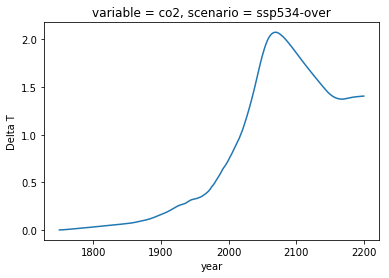

In [131]:
for per in IRFpercentiles:
    dic_ds[per].isel(scenario=0, variable=0)[name_deltaT].plot()
plt.show()

### Make datset with percentile as dimension:
Does really only make sense with percentiles...

In [132]:
ds_tmp = xr.Dataset(coords=dic_ds[recommendation].coords)
ds_tmp
for key in IRFpercentiles:
    ds_tmp[key] = dic_ds[key]['Delta T']  # .dims,dic_ds[key],)
ds['Delta T'] = ds_tmp.to_array('percentile')

# Save dataset:

In [133]:
ds.sel(year=slice(first_y, last_y)).to_netcdf(PATH_DT_OUTPUT)
print(f'Saved to {PATH_DT_OUTPUT}')
# ds_DT.to_array('percentile')
# dic_ds[key]['Delta T']

Saved to /home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/data_out/dT_data_RCMIP_recommendation.nc


## Double check historical $\Delta$ T: 


In [137]:
from matplotlib.ticker import (MultipleLocator)

from ar6_ch6_rcmipfigs.utils.plot import get_cmap_dic

In [138]:
ls_vars = ['aerosol-total', 'ch4', 'co2', 'other_wmghg', 'o3','HFCs']

In [139]:
cdic = get_cmap_dic(ls_vars)

(0.5607843137254902, 0.0, 0.6470588235294118)
(1.0, 0.4196078431372549, 0.07450980392156863)
(0.9568627450980393, 0.796078431372549, 0.21176470588235294)
(0.5254901960784314, 0.7803921568627451, 0.29411764705882354)
(0.21568627450980393, 0.49411764705882355, 0.7215686274509804)


In [140]:
ds

<xarray.Dataset>
Dimensions:     (percentile: 1, scenario: 11, variable: 19, year: 451)
Coordinates:
  * year        (year) int64 1750 1751 1752 1753 1754 ... 2197 2198 2199 2200
  * variable    (variable) <U30 'co2' 'ch4' ... 'HFCs'
  * scenario    (scenario) <U25 'ssp534-over' ... 'ssp370-lowNTCF-gidden'
  * percentile  (percentile) <U14 'recommendation'
Data variables:
    ERF         (scenario, variable, year) float64 ...
    time        (year) datetime64[ns] 1750-01-01 1751-01-01 ... 2200-01-01
    delta_t     (year) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    Delta T     (percentile, scenario, variable, year) float64 0.0 ... 0.06931

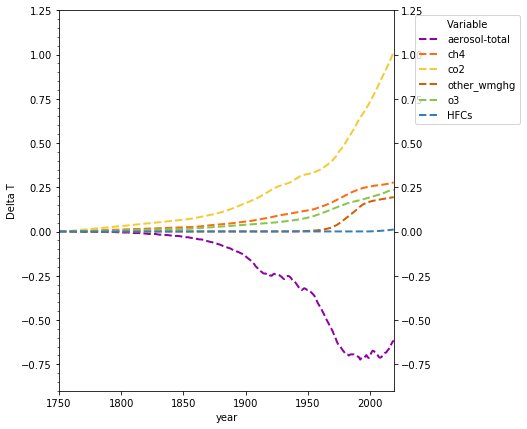

In [141]:

fig, ax = plt.subplots(figsize=[6, 7])

ds_hist = ds.sel(year=slice(1750, 2019), percentile=recommendation, scenario='ssp119', variable=ls_vars)
for var in ds_hist.variable.values:
    ds_hist.sel(variable=var)[name_deltaT].plot(label=var, linestyle='dashed', linewidth=2, c=cdic[var])
plt.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')  # , prop=fontP)
ax.yaxis.set_major_locator(MultipleLocator(.25))
ax.yaxis.set_minor_locator(MultipleLocator(.05))
ax.tick_params(right=True, labelright=True)
ax.set_xlim([1750, 2019])
ax.set_ylim([-0.9, 1.25])
plt.title('')
plt.show()

In [142]:
ds.close()